# Quality assessment: Glaciers distribution data from the Randolph Glacier Inventory for year 2000

### Use case: Estimating current global glacier ice volumes for glaciological, hydrological, and climatological applications.

### Use question: What is the temporal distribution of the digitized glaciers outlines, nominally provided for the year 2000 AD, and how well can they be used to estimate global glacier ice volumes?

This script summarizes the quality assessment provided for the C3S_520 service regarding 'Glaciers distribution data from the Randolph Glacier Inventory for year 2000' as they are available on the Climate Data Store (CDS) [version 6.0].

## High-level abstract

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacier characteristics and their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000' dataset that is on the CDS provides key information with respect to glacier extent and their characteristics. The RGI dataset namely is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 AD. As it is the most complete dataset of glacier outlines with a global coverage, researchers often take this data to represent the current state of all glaciers and it has therefore been used accordingly for an impressive amount of (modelling) studies as a reference dataset. However, although the goal of the dataset is to provide glacier outlines of all glaciers on Earth as close as possible to the year 2000, one of the main known issues of the dataset is the fact that the date of origin of the digitized glacier data varies substantially. This notebook investigates the corresponding temporal distribution of digitized glacier data and evaluates its implications for the estimation of current global glacier ice volumes using the example of Farinotti et al. (2019). The main results show that, due to the observed worldwide shrinkage of the glacierized area during the last several decades, a very likely underestimation of the ice volume estimate for 2000 AD occurs for glaciers digitized after 2000 AD, while else a very likely volume overestimation occurs. The magnitude of this over- or underestimation depends on the deviation of the date of digitization of the glacier from 2000 AD and the corresponding area change between 2000 AD and this deviation. It is worth noting that this volume under/overestimation strongly depends on the glacier characteristics (e.g. its date of digitization, its volume response time (that relates to the climatic regime and topographic/geometric glacier features), the debris-covered area (and the associated error of the glacier outline), etc.) and is thus highly glacier- and region-specific. This info can, however, be important for glaciological, hydrological, and climatological studies, such as the quantification of the sea level equivalent of a given volume of ice.

## Setup, data retrieval and methodology

#### Short description

The dataset of the glaciers distribution on the CDS is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale (RGI Consortium, 2017). The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000 AD, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). It also devides the glaciers into seperate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS. The resulting glacier extent data can be downloaded in vector topology or as raster-based data. 

In this notebook, the applicability of RGIv6.0 data to serve as an input for current global glacier ice volumes will be assessed by analyzing the temporal distribution of the dates of origin of the digitized glacier data, discussing the potential limitations and error sources of the dataset, and evaluating the implications for estimating current global glacier ice volumes based upon the example of Farinotti et al. (2019). Potential volume over/underestimation due to outdated glacier outlines will furthermore be quantified for each RGI region seperately using the global glacier mass change data that are on the CDS.

#### Import packages

In [117]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xesmf as xe
import xarray as xr
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

#### Define requests for download from the CDS

In [118]:
period_start = "1975_1976"
period_stop = "2020_2021"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

request_extent = (
    "insitu-glaciers-extent",
    {
        "variable": "all",
        "format": "zip",
        "version": "6_0",
    },
)

y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
request_mass_change = (
    "derived-gridded-glacier-mass-change",
    {
        "variable": "glacier_mass_change",
        "product_version": "wgms_fog_2022_09",
        "format": "zip",
        "hydrological_year": [
            f"{y0}_{str(y1)[-2:]}"
            for y0, y1 in zip(
                range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1)
            )
        ],
    },
)

#### Download, handle and open data

Since the data files to be downloaded and manipulated are quite large, this may take a couple of minutes.

In [121]:
# Get glacier extent data: takes a couple of minutes

print("Downloading glacier extent data from the CDS, this may take a couple of minutes...")
df = download.download_and_transform(*request_extent).to_pandas()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["CENLON"], df["CENLAT"]),
    crs="EPSG:4326",
)
print("Download completed.")

# Convert dates from string to datetime, and add digitalization year
columns = []
for column in ("BGNDATE", "ENDDATE"):
    years = gdf[column].str[:4]
    months = gdf[column].str[4:6].replace("99", "01")
    days = gdf[column].str[6:8].replace("99", "01")
    date = years + months + days
    date = date.where(~date.str.startswith("-"))
    columns.append(pd.to_datetime(date))
dates = pd.DataFrame(columns).mean()
year = dates.dt.year.astype("Int64")
gdf["decimal_year"] = year + (dates.dt.dayofyear - 1) / (364 + dates.dt.is_leap_year)
gdf["year"] = year

print("Downloading glacier mass change data from the CDS...")
# Get glacier mass change data
ds = download.download_and_transform(
    *request_mass_change,
    chunks={"hydrological_year": 1},
)

print("Performing some data handling...")
# Mask data for RGI regions
regions = gdf["RGIID"].str[6:8].astype(int)
da = regions.to_xarray().assign_coords(
    lon=gdf["CENLON"].to_xarray(),
    lat=gdf["CENLAT"].to_xarray(),
)
regridder = xe.Regridder(da, ds, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
ds = ds.where(mask)

# Compute cumulative fields
ds = ds.sum(("latitude", "longitude"), keep_attrs=True)
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Compute and add cumulative
cumulative = ds["Glacier"].cumsum("time")
cumulative.attrs = {
    "units": ds["Glacier"].attrs["units"].split()[0],
    "long_name": f"Cumulative {ds['Glacier'].attrs['long_name']}",
}
ds["Cumulative"] = cumulative
print("Downloading from the CDS and data handling completed.")

Transforming data into a GeoDataFrame...
Download completed.


100%|██████████| 46/46 [00:05<00:00,  8.84it/s]


Performing some data handling...


#### Define functions to be used

In [122]:
def plot_map(gdf, var_name=None, label=None, title=None, **kwargs):
    fig = plt.figure(figsize=(20,10))
    kwargs = {"markersize": 1, "legend": var_name is not None} | kwargs
    if var_name:
        kwargs = {"c": var_name, "column": var_name} | kwargs
        kwargs.setdefault("legend_kwds", {"shrink": 0.49, "extend": "both"})
        if label is not None:
            kwargs["legend_kwds"].setdefault("label", label)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gdf.plot(ax=ax, **kwargs)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=15)
    return ax

def weighted_average(df, field_name, weights_name):
    df = df[df[field_name].notnull() & df[weights_name].notnull()]
    weights = df[weights_name]
    return (df[field_name] * weights).sum() / weights.sum()

## Results and discussion

#### How close is the information on each of the glaciers to the year 2000 AD?

We can answer this question by extracting information from the attribute table of the downloaded shapefile. For some glaciers the outline is composed from several scenes over multiple years implying that a begin date (attribute "BGNDATE") and an end date (attribute "ENDDATE") is given in the attribute table. For these glaciers, we calculate the mean of the begin and end year:

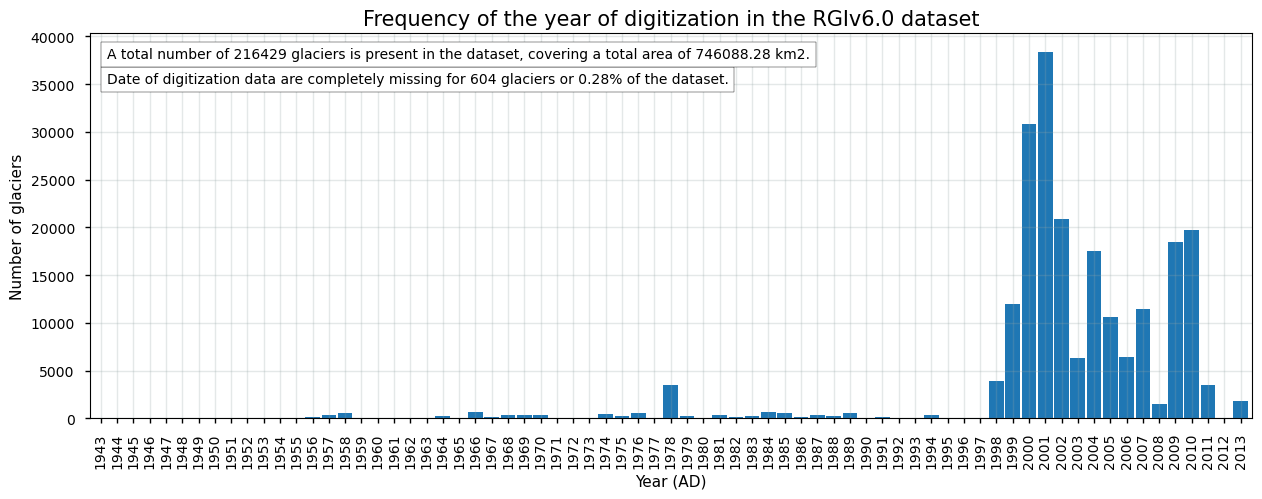

In [123]:
# Get data from years
size = gdf.set_index("year").groupby("year").size()
size = size.reindex(range(gdf["year"].min(), gdf["year"].max() + 1), fill_value=0)
missing = gdf["year"].isnull().sum()
missing_perc = 100 * (missing / len(gdf["year"]))
# Get some statistics
n_glaciers = len(gdf)
total_area = gdf["AREA"].sum()
# Plot data
ax = size.plot.bar(
    figsize=(15, 5),
    grid=True,
    width=0.9,
    ylabel="Number of glaciers",
    xlabel="Year (AD)",
)
_ = ax.text(
    0.015,
    0.87,
    f"Date of digitization data are completely missing for {missing} glaciers or {missing_perc:.2f}% of the dataset.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
_ = ax.text(
    0.015,
    0.935,
    f"A total number of {n_glaciers} glaciers is present in the dataset, covering a total area of {total_area:.2f} km2.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_title("Frequency of the year of digitization in the RGIv6.0 dataset",fontsize=15);

Let us check the spatial distribution of the year of digitization for each glacier in the dataset. We therefore produce a world map where every dot represents a glacier, that is colored according to its year of digitization:

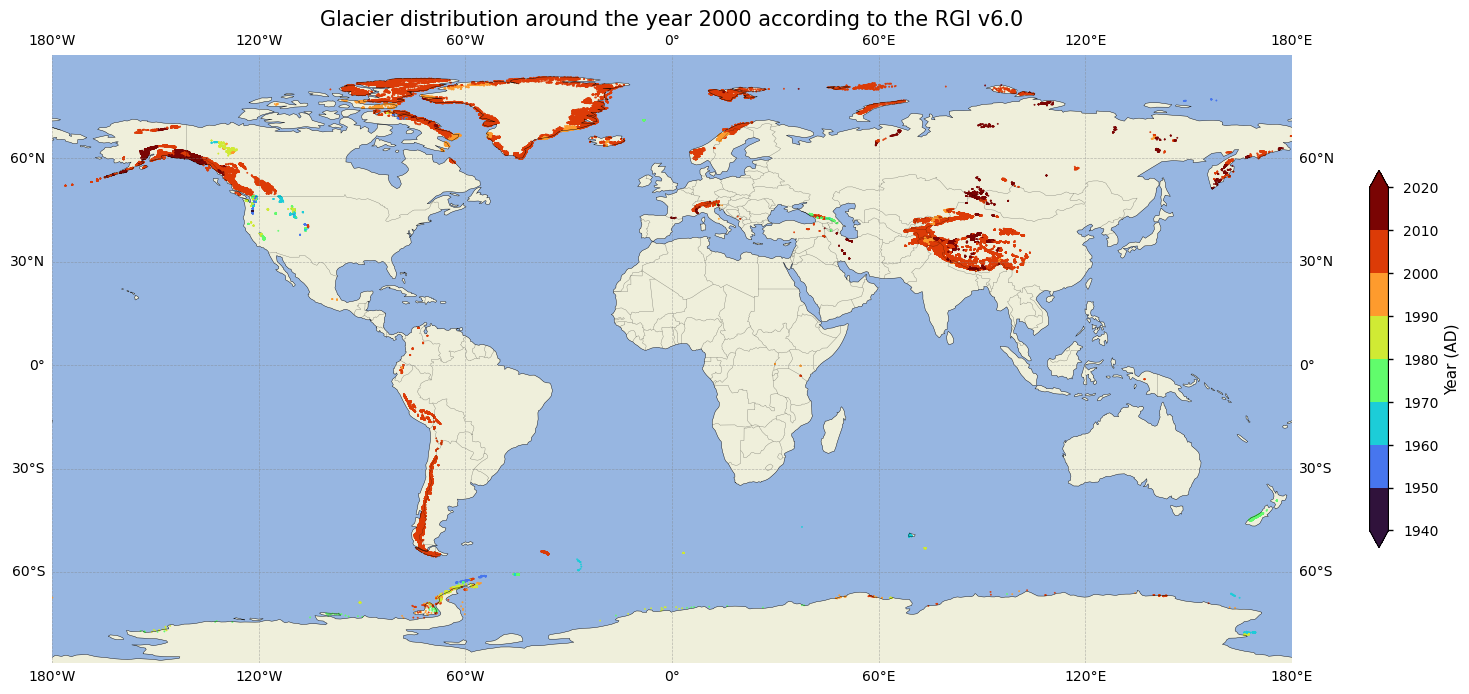

In [124]:
cmap = mpl.cm.turbo
norm = mpl.colors.BoundaryNorm(range(1940, 2021, 10), cmap.N)
ax = plot_map(
    gdf,
    var_name="year",
    cmap=cmap,
    norm=norm,
    label="Year (AD)",
    title="Glacier distribution around the year 2000 according to the RGI v6.0",
)

From the above plots, it becomes clear that not all glaciers are digitized in the year 2000 AD. Although the dataset is intended to be a snapshot of the world’s glaciers as they were near the beginning of the 21st century, the user must keep in mind that the range of digitization dates is substantial. This means that the outlines do not all lie in the same time frame, which is a main issue of the dataset. The figures above demonstrate that most outlines originate from the period between 2000 and 2010 AD. However, for some areas like New Zealand, the Caucasus or the western United States, the glacier outlines date back to the 1970s or earlier. The dataset is intended to be representative for “around the year 2000 AD”, while in fact the temporal coverage of the outlines from individual glacier ranges from the 1940s into the 2010s AD. The large heterogenity with respect to the year of digitization of the glacier outlines is a major limitation of the dataset and the user should take note of that before using a specific glacier outline. 

We can also calculate the average and area-weighted average time of digitization, for the dataset as a whole but also for each of the different 19 RGI regions:

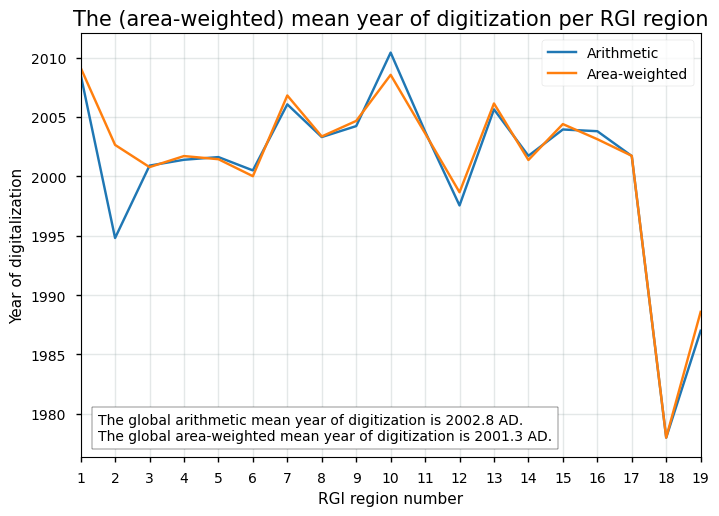

In [127]:
gdf["region"] = gdf["RGIID"].str[6:8].astype(int)
grouped = gdf[["year", "decimal_year", "AREA", "region"]].groupby("region")
ungrouped = gdf[["year", "decimal_year", "AREA", "region"]]
means = {
    "Arithmetic": grouped["decimal_year"].mean(),
    "Area-weighted": grouped.apply(
        weighted_average, "decimal_year", "AREA", include_groups=False
    ),
}
for label, mean in means.items():
    ax = mean.plot(label=label)
ax.set_xlabel("RGI region number")
ax.set_ylabel("Year of digitalization")
ax.legend()
textstr = '\n'.join((
    'The global arithmetic mean year of digitization is %.1f AD.' % (gdf["decimal_year"].mean(), ),
    'The global area-weighted mean year of digitization is %.1f AD.' % (mean.mean()),
));
ax.text(1.5, 1977.8, textstr, bbox={"facecolor":"white","edgecolor":"black"});
ax.set_xticks(np.linspace(1,max(gdf["region"]),max(gdf["region"])))
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(gdf["region"]),np.max(gdf["region"]))
ax.set_title("The (area-weighted) mean year of digitization per RGI region",fontsize=15);

We observe that at the global scale, the area-weighted average of the year of digitization is close to 2001 AD, which only slighly differs in time from the nominally stated dataset reference time (i.e. 2000 AD). However, the (area-weigthed) average of the time of digitization varies notably across the different RGI regions: for New-Zealand (RGI region 18), for example, the area-weighted average is 1978 AD, for Svalbard (RGI region 7) it is close to 2007 AD.

#### What are the other potential sources of error and uncertainty of the digitized glacier outline data?

Apart from a substantial deviation of the derived glacier data to the year 2000 AD, other potential sources of uncertainty include a low resolution and quality of the source data (e.g. the Digital Elevation Model and the degree of smoothing which impacts surface slopes), a poor skill of the digitizer, the presence of shadow or clouds on the satellite images, poor availability of multi-temporal satellite images, the presence of supraglacial and proglacial lakes, and the presence of seasonal snow fields. The largest source of misdelineation of glaciers is, however, the presence of supraglacial debris. For glaciers with extensive debris cover or for rock glaciers, the accuracy can therefore be significantly impacted (Paul et al., 2013). This is related to the fact that the spectral signature of debris is very similar to that of the surrounding moraines and bedrock. In regions with large debris cover (e.g. High Mountain Asia or the Caucasus), the user should be aware that the glacier area can be significantly underestimated due to the presence of debris. 

Another issue of the dataset is the unclear interpretation of what a glacier is. As the glacier outlines were created by a globally diverse community, the interpretation of what a glacier or ice cap is (do ice walls need to be included, how do tributaries need to be treated, which type of glaciers should be added, how to divide glacier complexes into seperate entities, from which threshold size onwards can we speak of a glacier) deviates among data sources. In this context, rock glaciers and also the peripheral glaciers of Antarctica and Greenland (where it is difficult to distinguish the ice sheet from the glaciers) remain a struggle (Hock et al., 2022). Specific attention of the user is therefore required in these areas. Ice bodies smaller than a regionally variable threshold size were furthermore not added (as being the supposed minimum size for ice flow and also to exclude snow fields). This implies that in some regions, glaciers smaller than this threshold were not included in the dataset, which leads to an underestimation of the glacier surface (RGI Consortium, 2017). 

Quantitative estimates of the errors and the related uncertainty are not given in the data. However, an error model can be found in Pfeffer et al. (2014). Here, it is stated that the relative error of the glacier area is larger for small glaciers than for large glaciers because small glaciers have a larger outline to area ratio. Based on the above, the uncertainty of an individual glacier outline, supposingly being representative for 2000 AD, therefore depends upon both the quality of the source material and the characteristics of the specific glacier.

#### How well can the data be used to estimate current global glacier ice volumes?

Several methods exist in the literature to derive ice thickness and ice volumes estimates of glaciers at different spatial scales, of which the most well-known procedures are the volume-area scaling method, numerical modelling, and the estimation of ice thicknesses from surface characteristics and the principle of ice dynamics. These methods, however, strongly rely on the precise determination of the glacier surface area (and hypsometry) to derive total ice volume estimates. Farinotti et al. (2019) used the latter method to derive a consensus estimate of global ice thickness values and the current global glacier ice volume for all glaciers digitized in the RGIv6.0 dataset. They found a total global glacier ice volume of 158.17 ± 41.03 10^3 km^3. The authors stated that the quality of their ice volume estimates highly depends upon the quality of the input data. Other studies using (earlier versions of) the RGI glacier extent data to derive regional or global glacier ice volumes report the same concerns and general sources of uncertainty in the input data (e.g. Huss and Farinotti, 2012; Marzeion et al., 2012; Milan et al., 2022).

Although the RGIv6.0 data do not include information on temporal changes of the glacier extent, Zemp et al. (2015),  Li et al. (2019) and Zemp et al. (2019) concluded that glacier retreat has been dominant during the last several decades, with the 21st century marking the historical minimum glacier extent in almost all regions across the globe since at least the 1500s. Results from Li et al. (2019) show that during the period 1980–2015, the rate of global glacier area change was -0.18% per year. Zemp et al. (2019) estimates this number to be -0.34% per year between 1961-2016. From a global record of 471 glacier length change data, Leclerq et al. (2014) furthermore found a median retreat rate over the 1961-2000 period of 7.4 meter per year. These findings indicate rapidly changing glacier conditions (and outlines), with observed glacier shrinkage and retreat in every RGI region during the last several decades (Li et al., 2019). The observed changes of the glacierized area from the literature imply a very likely overestimation of the volume estimate for glaciers digitized before 2000 AD (e.g. New-Zealand), and an underestimation else (e.g. Svalbard). The actual retreat and shrinkage (i.e. volume response time) of individual glaciers, however, is dictated by both geometric/topographic factors, such as the slope and the initial glacier size, and on local climatic conditions (Zemp et al., 2015). Eventually, the suitability of RGI outlines to be used for current glacier ice volume estimation depends on the magnitude of the deviation of the time of digitization from the year 2000 AD and the glacier area change, that would have potentially affacted the outlines, between 2000 AD and this deviation. 

Some studies have also investigated the choice of the glacier inventory on glacier ice volume estimates. For example, Li et al. (2022) found differences in ice volume of 2 to 8% in the Tien Shan when comparing two different glacier inventories, one of them being the RGIv6.0. Van Wyk de Vries et al. (2022) concluded that RGIv6.0 polygons overestimate the spatial extent of the majority of glaciers in the Northern Andes, likely due to rapid recent glacier recession, leading them to correct the outlines for their estimates. Bahr and Radić (2012) furthermore found that the omission of glaciers <0.01 km^2 (as done in the RGIv6.0) can lead to errors in regional ice volume of up to 10%. At last, Huss and Farinotti (2012) quantified the bulk uncertainties in their ice volume calculation due to imperfections in the (earlier-version) RGI shapes as varying between 1 and 8%, depending on the RGI region. Farinotti et al. (2019) did not perform any sensitivity experiment regarding the glacier outlines.

#### Example: quantifying potential volume over- or underestimation in different RGI regions

One way of quantifying the potential over- or underestimation of global glacier ice volumes relative to the year 2000 AD, due to not taking into account temporally changing glacier outlines, is to use the glacier mass change dataset that is on the CDS. The dataset estimates the gridded yearly mass loss of glacier ice at the global scale in Gt, which can be easily converted to km^3 of ice. Since this dataset takes into account the rate of change of the glacierized area for each RGI region from Zemp et al. (2019) to derive their corresponding mass changes, the data can be used to quantify the over- or underestimation of the glacier volume if the deviation of the area-weighted average time of digitization to the year 2000 AD for a particular RGI region is known. We therefore calculate the volume loss between 2000 AD and the area-weighted average year of digitization (as calculated above) between each RGI region by using the "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database". We make use of a conversion factor of 1 Gt = 1.091 km^3 of ice. Let us apply this to the 19 different RGI regions in the RGIv6.0 dataset:

In [126]:
year = 2000
original = ds.reset_coords()["Cumulative"]
interpolated = original.interp(time=means["Area-weighted"].to_xarray())
estimate = 1.091 * (interpolated - original.sel(time=year)).compute()
for region, result in estimate.groupby("region", squeeze=False):
    print(
        f"The volume estimate in RGI region {region:>2}"
        f" for the year {year} AD is"
        f" {'under' if result <0 else 'over':>5}estimated"
        f" by {abs(float(result)):.2f} km3."
    )

total = estimate.sum()
print(
    f"\nThe volume estimate at the global scale"
    f" for the year {year} AD is"
    f" {'under' if result <0 else 'over'}estimated"
    f" by {abs(float(total)):.2f} km3."
)

The volume estimate in RGI region  1 for the year 2000 AD is underestimated by 556.37 km3.
The volume estimate in RGI region  2 for the year 2000 AD is underestimated by 23.99 km3.
The volume estimate in RGI region  3 for the year 2000 AD is underestimated by 13.31 km3.
The volume estimate in RGI region  4 for the year 2000 AD is underestimated by 30.21 km3.
The volume estimate in RGI region  5 for the year 2000 AD is underestimated by 46.84 km3.
The volume estimate in RGI region  6 for the year 2000 AD is underestimated by 0.09 km3.
The volume estimate in RGI region  7 for the year 2000 AD is underestimated by 92.91 km3.
The volume estimate in RGI region  8 for the year 2000 AD is underestimated by 11.83 km3.
The volume estimate in RGI region  9 for the year 2000 AD is underestimated by 72.72 km3.
The volume estimate in RGI region 10 for the year 2000 AD is underestimated by 11.09 km3.
The volume estimate in RGI region 11 for the year 2000 AD is underestimated by 4.92 km3.
The volume 

Here, it is clear that especially RGI regions 1 (Alaska) and 19 (Antarctic and Subantarctic) exhibit a relatively large underestimation of the total glacier ice volume, mainly due to their large deviation of the  area-weighted average year of digitization to the year 2000 AD, as well as the large glacier ice volume changes during this deviatoric period. At the global scale, glacier ice volume estimates would exhibit an underestimation of ca. 1200 km^3 due to outdated glacier outlines, which is only ca. 0.75% of the total glacier ice volume estimate by Farinotti et al. (2019). Glacier ice volumes are only overestimated in RGI regions 12 (Caucasus and Middle East) and 18 (New-Zealand). Percentage-wise, the highest errors relative to the total glacier ice volume in a certain region occurs in RGI regions 10 (North Asia, 7.92%), 18 (New-Zealand, 4.97%) and 16 (Low Latitudes, 4.02%). The above obtained error related to the outdated glacier outlines from RGIv6.0 is thus relatively low at the global-scale when compared to the total global glacier ice volume estimate from Farinotti et al. (2019), implying that the dataset is well-suited to estimate current global glacier ice volumes for the year 2000 AD. The corresponding systematic error is, however, glacier- and region-dependent.

## Take-home messages

The glaciers distribution dataset that is on the CDS (here version v6.0 is used) is currently the most complete dataset of glacier outlines in terms of its spatial coverage. It is generally considered the main reference dataset to determine the glaciers distribution across the globe around the year 2000 AD. When using the RGI v6.0 dataset that is available on the CDS, users should be aware of the typical problems with the dataset. One of such problems is the fact that not all digitized glacier information exactly corresponds to data in the year 2000 AD, as is nevertheless stated in the title of the dataset. Nonetheless, although most information dates back to the timeframe between 2000 and 2010 AD, certain regions in the world exhibit information that dates further back into the 20th century and can hence be interpeted as outdated data. Other limitations to the dataset are, for example, the fact that in some cases, RGI outlines do not accurately represent actual glacier outlines (e.g. for debris-covered glaciers). 

It can be stated that, despite its known limitations, the glaciers distribution dataset that is available on the CDS is the main reference dataset for many glaciological applications. The RGIv6.0 data, as available on the CDS, were for example used in the estimation of current global glacier ice volumes (e.g. Farinotti et al., 2019) and their corresponding sea level equivalent. The authors, however, state that their estimates highly depend upon the quality of the input data. The limitations of the RGIv6.0 dataset, such as the long aggregation period, should therefore be kept in mind when assessing current global ice volume estimates, especially due to the observed worldwide accelerated glacier shrinkage and retreat over the last several decades. Depending on the magnitude of the deviation of the time of digitization from the year 2000 AD and the rate of area change between 2000 AD and this deviation, this systematic error in the RGI outlines may have significant implications for the current glacier ice volume estimation. Namely, due to the observed worldwide shrinkage of the glacierized area, a very likely underestimation of the ice volume estimate for 2000 AD occurs for glaciers digitized after 2000 AD, while else a very likely volume overestimation occurs. 

However, the corresponding systematic error (at the global scale) related to outdated glacier outlines in the RGIv6.0 obtained in this notebook is found to only comprise a small percentage (i.e. an underestimation of <1% when compared to total global glacier volume data from Farinotti et al. (2019)) of the total esitmated global glacier ice volumes, implying that the dataset is well-suited to be used for global glacier ice volume estimates. This is also corroborated by the fact that the global-scale area-weighted average year of digitization (2001.3 AD in RGIv6.0) is relatively close to reference time period of 2000 AD. The effect is, however, highly glacier- and region-specific, as it depends on e.g. glacier-specific time of digitization, the glacier volume response time (which is related to the climatic regime and topographic/geometric glacier features), its debris-covered area (causing errors to the glacier outline), etc. Users should therefore revise case-specific details before computing glacier-specific or region/global-scale volume estimates by using RGI outlines.

## References

Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

Hock, R., Maussion, F., Marzeion, B., and Nowicki, S. (2023). What is the global glacier ice volume outside the ice sheets? Journal of Glaciology, 69(273), 204–10. doi: 10.1017/jog.2023.1.

Huss, M., and Farinotti, D. (2012). Distributed ice thickness and volume of all glaciers around the globe, Journal of Geophysical Research, 117, F04010. doi: 10.1029/2012JF002523.

Leclercq, P. W., Oerlemans, J., Basagic, H. J., Bushueva, I., Cook, A. J., and Le Bris, R. (2014). A data set of worldwide glacier length fluctuations, Cryosphere, 2014(8), 659–672. doi: 10.5194/tc-8-659-2014.

Li, Y. J., Ding, Y. J., Shangguan, D. H., and Wang, R. J. (2019). Regional differences in global glacier retreat from 1980 to 2015, Advances in Climate Change Research, 10(4), 203–213. doi: 10.1016/j.accre.2020.03.003.

Marzeion, B., Jarosch, A. H., and Hofer, M. (2012). Past and future sea-level change from the surface mass balance of glaciers, The Cryosphere, 6, 1295–1322. doi: 10.5194/tc-6-1295-2012.

Millan, R., Mouginot, J., Rabatel, A., and Morlighem, M. (2022). Ice velocity and thickness of the world’s glaciers, Nature Geoscience, 15, 124–129. doi: 10.1038/s41561-021-00885-z.

Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

Zemp, M., Frey, H., Gärtnew-Roer, I., Nussbaumer, S. U., Helzle, M., Paul, F., Haeberli, W., Denzinger, F., Ahlstrøm, A. P., Anderson, B., Bajracharya, S., Baroni, C., Braun, L. N., Cáceres, B. E., Casassa, G., Cobos, G., Dávila, L. R., Delgado Granados, H., Demuth, M. N., Espizua, L., Fischer, A., Fujita, K., Gadek, B., Ghazanfar, A., Hagen, J. O., Holmlund, P., Karimi, N., Li, Z., Pelto, M., Pitte, P., Popovnin, V. V., Portocarrero, C. A., Prinz, R., Sangewar, C. V., Severskiy, I., Sigurdsson, O., Soruco, A., Usubaliev, R., and Vincent, C. (2015). Historically unprecedented global glacier decline in the early 21st century, Journal of Glaciology, 61, 745-762. doi: 10.3189/2015JoG15J017.

Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.